1. 1split (without dense)

In [1]:
import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
y_test = keras.utils.to_categorical(y_test)

In [1]:
from keras.models import Model
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation
from keras.utils import plot_model

# encoder
enc_input = Input(shape=(28,28,1), name='enc_input')
x  = Conv2D(filters=32, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same', name='conv1')(enc_input)
x  = Conv2D(filters=64, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same', name='conv2')(x)
x  = Conv2D(filters=1, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same', name='pt_conv1')(x)
x = Flatten(name='flatten')(x)
latent = Activation('sigmoid', name='latent')(x)

# decoder
dec_input = Input(shape=(16,), name='dec_input')
x = Dense(units=7*7*8, activation='relu', name='dense')(dec_input)
x = Reshape(target_shape=(7,7,8), name='reshape')(x)
x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same', name='deconv1')(x)
x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same', name='deconv2')(x)
dec_output = Conv2DTranspose(filters=1, kernel_size=3, padding='same', name='pt_conv')(x)

encoder = Model(enc_input, latent, name="Encoder")
decoder = Model(dec_input, dec_output, name="Decoder")
model = Model(encoder.input, decoder(encoder.output))

model.compile(loss='mse', optimizer='adam')
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_input (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 32)        160       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          8256      
_________________________________________________________________
pt_conv1 (Conv2D)            (None, 4, 4, 1)           257       
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
latent (Activation)          (None, 16)                0         
_________________________________________________________________
Decoder (Model)              (None, 28, 28, 1)         30089 

In [3]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('../models/48_1split.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

history = model.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=100, batch_size=32, callbacks=[es, mc])

Epoch 1/100
1869/1875 [============================>.] - ETA: 0s - loss: 0.0381
Epoch 00001: val_loss improved from inf to 0.02857, saving model to ../models/48_1split.h5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0380 - val_loss: 0.0286
Epoch 2/100
1871/1875 [============================>.] - ETA: 0s - loss: 0.0268
Epoch 00002: val_loss improved from 0.02857 to 0.02464, saving model to ../models/48_1split.h5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0268 - val_loss: 0.0246
Epoch 3/100
1865/1875 [============================>.] - ETA: 0s - loss: 0.0243
Epoch 00003: val_loss improved from 0.02464 to 0.02318, saving model to ../models/48_1split.h5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0243 - val_loss: 0.0232
Epoch 4/100
1866/1875 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 00004: val_loss improved from 0.02318 to 0.02201, saving model to ../models/48_1split.h5
1875/1875 [====================

2. 4split with free weights (without dense)

In [3]:
import keras
import math
import numpy as np

class dataGen(keras.utils.Sequence):
    def __init__(self, xs, batch_size=32):
        self.batch_size=batch_size
        self.xs = xs
        self.on_epoch_end()
    def __len__(self):
        return math.ceil(len(self.xs)/self.batch_size)
    def split(self, im, nrows=14, ncols=14):
        r, h = im.shape[:-1] # exclude channel dim
        return (im.reshape(h//nrows,nrows,-1,ncols).swapaxes(1,2).reshape(-1,nrows,ncols,1))
    def __getitem__(self, i):
        batch = self.xs[i*self.batch_size:(i+1)*self.batch_size]
        x1s, x2s, x3s, x4s = [], [], [], []
        for x in batch:
            x1, x2, x3, x4 = self.split(x)
            x1s.append(x1)
            x2s.append(x2)
            x3s.append(x3)
            x4s.append(x4)
        xs = [np.array(x1s), np.array(x2s), np.array(x3s), np.array(x4s)]
        return xs, batch
    def on_epoch_end(self):
        self.xs = np.random.permutation(self.xs)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
train_data = dataGen(x_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
test_data = dataGen(x_test)

In [2]:
from keras.models import Model
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, Activation
from keras.utils import plot_model
import keras

# encoder
latents = []
enc_inputs = [Input(shape=(14,14,1)) for _ in range(4)]
for i in range(4):
    conv1 = Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same')
    conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same')
    pt_conv = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), activation='sigmoid', padding='valid')
    latent = Flatten()
    
    enc_out = latent(pt_conv(conv2(conv1(enc_inputs[i]))))
    latents.append(enc_out)
latent_concat = keras.layers.concatenate(latents, name='latent_concat')

# decoder
dec_input = Input(shape=(16,), name='dec_input')
# x = Dense(units=7*7*8, activation='relu', name='dense')(dec_input)
# x = Reshape(target_shape=(7,7,8), name='reshape')(x)
x = Reshape(target_shape=(4,4,1))(dec_input)
x = Conv2DTranspose(filters=1, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid')(x)
x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same', name='deconv1')(x)
x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same', name='deconv2')(x)
dec_output = Conv2DTranspose(filters=1, kernel_size=3, padding='same', name='pt_conv')(x)

encoders = [Model(enc_inputs[i], latents[i], name='Encoder_%d'%i) for i in range(4)]
decoder = Model(dec_input, dec_output, name="Decoder")
model = Model(enc_inputs, decoder(latent_concat))

model.compile(loss='mse', optimizer='adam')
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 14, 14, 1)]  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 14, 14, 1)]  0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 14, 14, 1)]  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 14, 14, 1)]  0                                            
____________________________________________________________________________________________

In [4]:
history = model.fit(train_data, validation_data=(test_data), epochs=50)

Epoch 1/50
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0559 - val_loss: 0.0488
Epoch 2/50
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0458 - val_loss: 0.0441
Epoch 3/50
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0428 - val_loss: 0.0413
Epoch 4/50
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0412 - val_loss: 0.0401
Epoch 5/50
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0401 - val_loss: 0.0394
Epoch 6/50
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0392 - val_loss: 0.0388
Epoch 7/50
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0386 - val_loss: 0.0378
Epoch 8/50
1875/1875 [==============================] - 22s 11ms/step - loss: 0.0380 - val_loss: 0.0372
Epoch 9/50
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0374 - val_loss: 0.0367
Epoch 10/50
1875/1875 [==============================] - 21s 11m

3. 4split with tied weights

In [5]:
from keras.models import Model
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, Activation
from keras.utils import plot_model
import keras

# shared layers
enc_inputs = [Input(shape=(14,14,1)) for _ in range(4)]
conv1 = Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', name='conv1')
conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', name='conv2')
pt_conv = Conv2D(filters=1, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', name='pt_conv')
flatten = Flatten(name='flatten')
latent = Activation('sigmoid')

# encoder
latents = []
for i in range(4):
    enc_out = latent(flatten(pt_conv(conv2(conv1(enc_inputs[i])))))
    latents.append(enc_out)
latent_concat = keras.layers.concatenate(latents, name='latent_concat')

# decoder
dec_input = Input(shape=(16,), name='dec_input')
x = Dense(units=7*7*8, activation='relu', name='dense')(dec_input)
x = Reshape(target_shape=(7,7,8), name='reshape')(x)
x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same', name='deconv1')(x)
x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same', name='deconv2')(x)
dec_output = Conv2DTranspose(filters=1, kernel_size=3, padding='same', name='pt_conv')(x)

encoders = [Model(enc_inputs[i], latents[i], name='Encoder_%d'%i) for i in range(4)]
decoder = Model(dec_input, dec_output, name="Decoder")
model = Model(enc_inputs, decoder(latent_concat))

model.compile(loss='mse', optimizer='adam')
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14, 14, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 14, 14, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 14, 14, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 14, 14, 1)]  0                                            
____________________________________________________________________________________________

In [6]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('../models/48_4split_shared.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

history = model.fit(train_data, validation_data=(test_data), epochs=100, callbacks=[es, mc])

Epoch 1/100
1870/1875 [============================>.] - ETA: 0s - loss: 0.0375
Epoch 00001: val_loss improved from inf to 0.02818, saving model to ../models/48_4split_shared.h5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0375 - val_loss: 0.0282
Epoch 2/100
1871/1875 [============================>.] - ETA: 0s - loss: 0.0256
Epoch 00002: val_loss improved from 0.02818 to 0.02341, saving model to ../models/48_4split_shared.h5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0256 - val_loss: 0.0234
Epoch 3/100
1870/1875 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00003: val_loss improved from 0.02341 to 0.02149, saving model to ../models/48_4split_shared.h5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0230 - val_loss: 0.0215
Epoch 4/100
1870/1875 [============================>.] - ETA: 0s - loss: 0.0216
Epoch 00004: val_loss improved from 0.02149 to 0.02049, saving model to ../models/48_4split_shared.h5


4. Compare classification 1-split vs. 4-split(shared)

4.1. 1-split

In [20]:
import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
y_test = keras.utils.to_categorical(y_test)

In [5]:
from keras.models import Model
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation
from keras.utils import plot_model

# encoder
enc_input = Input(shape=(28,28,1), name='enc_input')
x  = Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', name='conv1')(enc_input)
x  = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', name='conv2')(x)
x  = Conv2D(filters=1, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', name='pt_conv1')(x)
x = Flatten(name='flatten')(x)
latent = Activation('sigmoid', name='latent')(x)

# decoder
dec_input = Input(shape=(16,), name='dec_input')
x = Dense(256, activation='relu')(dec_input)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
class_out = Dense(10, activation='softmax', name='classifier_out')(x)
# x = Dense(units=7*7*8, activation='relu', name='dense')(dec_input)
# x = Reshape(target_shape=(7,7,8), name='reshape')(x)
# x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same', name='deconv1')(x)
# x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same', name='deconv2')(x)
# dec_output = Conv2DTranspose(filters=1, kernel_size=3, padding='same', name='pt_conv')(x)

encoder = Model(enc_input, latent, name="Encoder")
decoder = Model(dec_input, class_out, name="Decoder")
model = Model(encoder.input, decoder(encoder.output))

model.compile(loss='mse', optimizer='adam')
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_input (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 32)        320       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          18496     
_________________________________________________________________
pt_conv1 (Conv2D)            (None, 4, 4, 1)           577       
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
latent (Activation)          (None, 16)                0         
_________________________________________________________________
Decoder (Model)              (None, 10)                4615

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
mc = ModelCheckpoint('../models/48_1split_class.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=32, callbacks=[es, mc])

Epoch 1/100
1849/1875 [============================>.] - ETA: 0s - loss: 0.6028 - accuracy: 0.8035
Epoch 00001: val_accuracy improved from -inf to 0.92260, saving model to ../models/48_1split_class.h5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5979 - accuracy: 0.8051 - val_loss: 0.2588 - val_accuracy: 0.9226
Epoch 2/100
1865/1875 [============================>.] - ETA: 0s - loss: 0.2385 - accuracy: 0.9270
Epoch 00002: val_accuracy improved from 0.92260 to 0.93090, saving model to ../models/48_1split_class.h5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2386 - accuracy: 0.9270 - val_loss: 0.2248 - val_accuracy: 0.9309
Epoch 3/100
1868/1875 [============================>.] - ETA: 0s - loss: 0.1886 - accuracy: 0.9429
Epoch 00003: val_accuracy improved from 0.93090 to 0.95490, saving model to ../models/48_1split_class.h5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1886 - accuracy: 0.9429 - val_loss: 0.1485 - val_accuracy:

In [23]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

n_splits = 4
output_shape = (28, 28, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14
latent_dim = 4

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

In [24]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout, MaxPooling2D
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, input_shape, output_shape):
        super(MultiSplit, self).__init__()
        self.encoder = self._create_encoder(latent_dim, input_shape)
        self.input_reshaper = utils.Reshaper((n_splits, *input_shape), input_shape)
        self.latent_reshaper = utils.Reshaper([latent_dim], [n_splits * latent_dim])
#         self.decoder = self._create_decoder(n_splits * latent_dim, output_shape)
        self.classifier = self._create_classifier(n_splits * latent_dim)
#         self.regressor = self._create_regressor(n_splits * latent_dim)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
#         y_pred['decoder_out'] = tf.image.extract_glimpse(y_pred['decoder_out'], (28,28), y['regressor_out'], centered=False, normalized=False, noise='zero')
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
#         y_reco = self.decode(z ,training=training)
        y_class = self.classify(z ,training=training)
#         y_regr = self.regress(z ,training=training)
        return y_class
#         return {"decoder_out": y_reco, "classifier_out": y_class, "regressor_out": y_regr}
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=1, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Activation('sigmoid')
#             Dense(units=latent_dim, activation='sigmoid')
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 8),  #! Reduce amount of neurons by 4.
            Reshape((io_shape[0]//4, io_shape[1]//4, 8)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax', name='classifier_out')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='relu'),
            Dense(2, activation='linear', name='regressor_out')
        ])

In [26]:
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
mc = ModelCheckpoint('../models/48_4split_shared_class.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

history = model.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=100, batch_size=32, callbacks=[es, mc])

Epoch 1/100
1859/1875 [============================>.] - ETA: 0s - loss: 0.8004 - accuracy: 0.7392
Epoch 00001: val_accuracy improved from -inf to 0.89220, saving model to ../models/48_4split_shared_class.h5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7969 - accuracy: 0.7403 - val_loss: 0.3509 - val_accuracy: 0.8922
Epoch 2/100
1867/1875 [============================>.] - ETA: 0s - loss: 0.3223 - accuracy: 0.8990
Epoch 00002: val_accuracy improved from 0.89220 to 0.92590, saving model to ../models/48_4split_shared_class.h5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3219 - accuracy: 0.8990 - val_loss: 0.2477 - val_accuracy: 0.9259
Epoch 3/100
1855/1875 [============================>.] - ETA: 0s - loss: 0.2423 - accuracy: 0.9243
Epoch 00003: val_accuracy improved from 0.92590 to 0.93060, saving model to ../models/48_4split_shared_class.h5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2413 - accuracy: 0.9245 - val_loss: 0

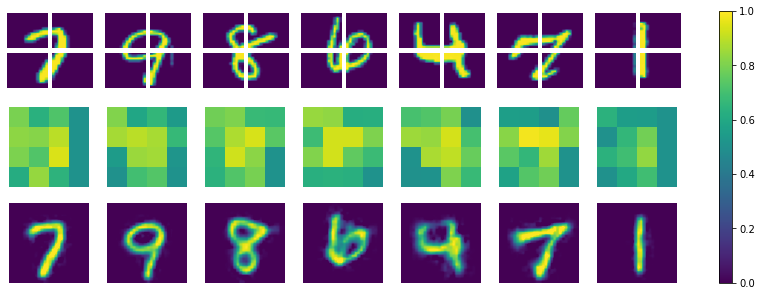

In [16]:
import matplotlib.pyplot as plt
import tensorflow as tf

n = 7
# n = 1
plt.figure(figsize=(15, 5))
axs = []
for (xs, ys), i in zip(test_data, range(n)):
#     axs.append(plt.subplot(3, n, i+1))
    ax = plt.subplot(3, n, i+1)
    for j in range(4):
        r = int(j/2)
        c = j%2
        ins = ax.inset_axes([c*0.55,0.5-r*0.5,0.5,0.5])
        ins.axis('off')
        ins.imshow(xs[j][0], vmin=0, vmax=1)
    ax.axis('off')
    axs.append(ax)
        
    z = [encoder(x[0].reshape(1,14,14,1)) for encoder, x in zip(encoders, xs)]
    a = np.empty((4,4))
    for j in range(4):
        r = int(j/2)
        c = j%2
        a[r*2:(r+1)*2, c*2:(c+1)*2] = tf.reshape(z[j], (2,2))
    axs.append(plt.subplot(3, n, n+i+1))
    plt.axis('off')
    plt.imshow(a, vmin=0, vmax=1)
    
    y = model.predict(xs)
    axs.append(plt.subplot(3, n, 2*n+i+1))
    plt.axis('off')
    plt.imshow(tf.reshape(y[0], (28,28)), vmin=0, vmax=1)
plt.colorbar(ax=axs)

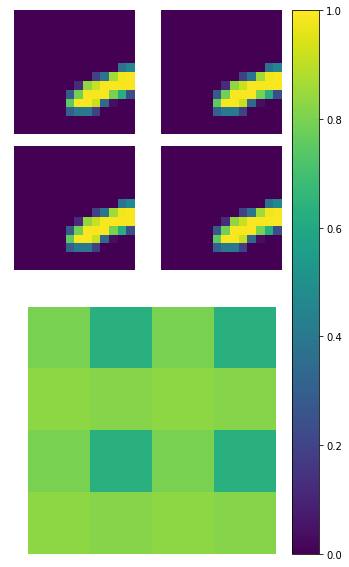

In [17]:
import matplotlib.pyplot as plt
import tensorflow as tf

# model.load_weights('../weights/41_CAE4x4_epoch50_freeWeights_weights.h5')
# n = 7
n = 1
# plt.figure(figsize=(15, 5))
plt.figure(figsize=(6, 10))
axs = []
for (xs, ys), i in zip(test_data, range(n)):
#     axs.append(plt.subplot(3, n, i+1))
#     ax = plt.subplot(3, n, i+1)
    ax = plt.subplot(2, 1, 1)
    for j in range(4):
        r = int(j/2)
        c = j%2
#         ins = ax.inset_axes([c*0.55,0.5-r*0.5,0.5,0.5])
        ins = ax.inset_axes([c*0.55,0.5-r*0.55,0.5,0.5])
        ins.axis('off')
        ins.imshow(xs[0][0], vmin=0, vmax=1)
    ax.axis('off')
    axs.append(ax)
        
    z = [encoder(xs[0][0].reshape(1,14,14,1)) for encoder, x in zip(encoders, xs)]
    a = np.empty((4,4))
    for j in range(4):
        r = int(j/2)
        c = j%2
        a[r*2:(r+1)*2, c*2:(c+1)*2] = tf.reshape(z[j], (2,2))
#     axs.append(plt.subplot(3, n, n+i+1))
    axs.append(plt.subplot(2, 1, 2))
    plt.axis('off')
    plt.imshow(a, vmin=0, vmax=1)
    
#     y = model.predict(xs)
#     axs.append(plt.subplot(3, n, 2*n+i+1))
#     plt.axis('off')
#     plt.imshow(tf.reshape(y[0], (28,28)), vmin=0, vmax=1)
plt.colorbar(ax=axs)

In [1]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, n_width, n_height):
    ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(n_width-width)
        y = np.random.randint(n_height-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
output_shape = (56, 56, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14
latent_dim = 4

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

# 16-split reco performance

In [2]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout, MaxPooling2D
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, input_shape, output_shape):
        super(MultiSplit, self).__init__()
        self.encoder = self._create_encoder(latent_dim, input_shape)
        self.input_reshaper = utils.Reshaper((n_splits, *input_shape), input_shape)
        self.latent_reshaper = utils.Reshaper([latent_dim], [n_splits * latent_dim])
        self.decoder = self._create_decoder(n_splits * latent_dim, output_shape)
        self.classifier = self._create_classifier(n_splits * latent_dim)
        self.regressor = self._create_regressor(n_splits * latent_dim)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        y_pred['decoder_out'] = tf.image.extract_glimpse(y_pred['decoder_out'], (28,28), y['regressor_out'], centered=False, normalized=False, noise='zero')
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_reco = self.decode(z ,training=training)
        y_class = self.classify(z ,training=training)
        y_regr = self.regress(z ,training=training)
        return {"decoder_out": y_reco, "classifier_out": y_class, "regressor_out": y_regr}
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=1, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Activation('sigmoid')
#             Dense(units=latent_dim, activation='sigmoid')
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 8),  #! Reduce amount of neurons by 4.
            Reshape((io_shape[0]//4, io_shape[1]//4, 8)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax', name='classifier_out')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='relu'),
            Dense(2, activation='linear', name='regressor_out')
        ])

In [4]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 1.0,
    'classifier_out' : 0.0,
    'regressor_out' : 0.0
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])
print(model.encoder.summary())
print(model.decoder.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 7, 7, 32)          320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 1)           577       
_________________________________________________________________
flatten_1 (Flatten)          (None, 4)                 0         
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 19,393
Trainable params: 19,393
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_3"
_________________________________________________________________
Layer (type)                

In [5]:
history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
                    epochs=50, batch_size=32)

Epoch 1/50
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0190 - classifier_out_loss: 2.3239 - decoder_out_loss: 0.0190 - regressor_out_loss: 99.7312 - classifier_out_accuracy: 0.0967 - decoder_out_accuracy: 0.9474 - regressor_out_accuracy: 0.4986 - val_loss: 0.0469 - val_classifier_out_loss: 2.3191 - val_decoder_out_loss: 0.0469 - val_regressor_out_loss: 99.7600 - val_classifier_out_accuracy: 0.0966 - val_decoder_out_accuracy: 0.7826 - val_regressor_out_accuracy: 0.5017
Epoch 2/50
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0109 - classifier_out_loss: 2.3199 - decoder_out_loss: 0.0109 - regressor_out_loss: 99.7597 - classifier_out_accuracy: 0.0956 - decoder_out_accuracy: 0.9469 - regressor_out_accuracy: 0.4970 - val_loss: 0.0405 - val_classifier_out_loss: 2.3193 - val_decoder_out_loss: 0.0405 - val_regressor_out_loss: 99.7590 - val_classifier_out_accuracy: 0.0969 - val_decoder_out_accuracy: 0.7944 - val_regressor_out_accuracy: 0.4957
Epoc

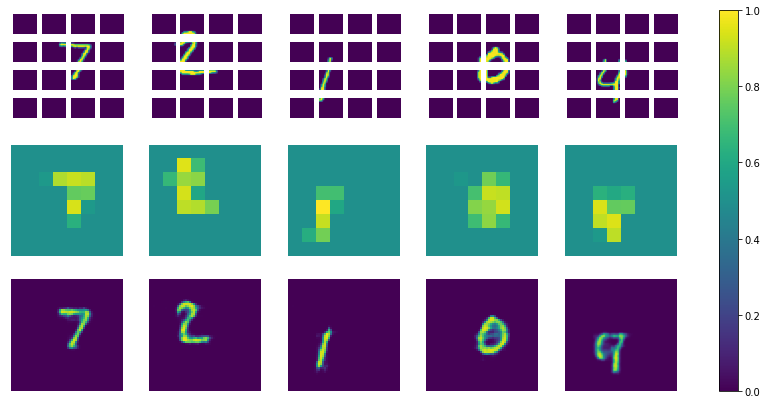

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf

n = 5
plt.figure(figsize=(15, 7))
axs = []
for i in range(n):
    
    # predict
    x = x_test_split[i].reshape(1,16,14,14,1)
    z = model.encode(x, training=False)
    y = model.decode(z, training=False)

    a = np.empty((56,56))
    ax = plt.subplot(3, n, i+1)
    for j in range(16):
        r = int(j/4)
        c = j%4
#         ins = ax.inset_axes([c*0.25,0.25-r*0.25,0.20,0.20])
        ins = ax.inset_axes([0.05+c*0.25,0.75-r*0.25,0.20,0.25])
        ins.axis('off')
        ins.imshow(tf.reshape(x[0][j], (14, 14)), vmin=0, vmax=1)
    ax.axis('off')
    axs.append(ax)
    
#     ax = plt.subplot(3, n, i+1)
#     plt.axis('off')
#     axs.append(plt.imshow(x_test_augmented[i].reshape(56,56), vmin=0, vmax=1))
    
    a = np.empty((8,8))
    for j in range(16):
        r = int(j/4)
        c = j%4
        a[r*2:(r+1)*2, c*2:(c+1)*2] = tf.reshape(z[j], (2,2))
    ax = plt.subplot(3, n, n+i+1) 
    plt.axis('off')
    plt.imshow(a, vmin=0, vmax=1)
    axs.append(ax)
    
    ax = plt.subplot(3, n, 2*n+i+1) 
    plt.axis('off')
    plt.imshow(tf.reshape(y, (56,56)), vmin=0, vmax=1)
    axs.append(ax)
plt.colorbar(ax=axs)
plt.savefig('../img/48_PLOTS/16split_reco_expl.png',  bbox_inches='tight', transparent=True, pad_inches=0)

In [8]:
model.save_weights('../weights/48_CAE4x16_epoch50_weights.h5')

# Add more filters to decoder 8->16

In [2]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout, MaxPooling2D
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, input_shape, output_shape):
        super(MultiSplit, self).__init__()
        self.encoder = self._create_encoder(latent_dim, input_shape)
        self.input_reshaper = utils.Reshaper((n_splits, *input_shape), input_shape)
        self.latent_reshaper = utils.Reshaper([latent_dim], [n_splits * latent_dim])
        self.decoder = self._create_decoder(n_splits * latent_dim, output_shape)
        self.classifier = self._create_classifier(n_splits * latent_dim)
        self.regressor = self._create_regressor(n_splits * latent_dim)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        y_pred['decoder_out'] = tf.image.extract_glimpse(y_pred['decoder_out'], (28,28), y['regressor_out'], centered=False, normalized=False, noise='zero')
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_reco = self.decode(z ,training=training)
        y_class = self.classify(z ,training=training)
        y_regr = self.regress(z ,training=training)
        return {"decoder_out": y_reco, "classifier_out": y_class, "regressor_out": y_regr}
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=1, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Activation('sigmoid')
#             Dense(units=latent_dim, activation='sigmoid')
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 16),  #! Reduce amount of neurons by 4.
            Reshape((io_shape[0]//4, io_shape[1]//4, 16)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax', name='classifier_out')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='relu'),
            Dense(2, activation='linear', name='regressor_out')
        ])

In [3]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 1.0,
    'classifier_out' : 0.0,
    'regressor_out' : 0.0
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam')

In [4]:
history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
                    epochs=50, batch_size=32)

Epoch 1/50
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0184 - classifier_out_loss: 2.3415 - decoder_out_loss: 0.0184 - regressor_out_loss: 100.7152 - val_loss: 0.0472 - val_classifier_out_loss: 2.3369 - val_decoder_out_loss: 0.0472 - val_regressor_out_loss: 100.6786
Epoch 2/50
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0108 - classifier_out_loss: 2.3365 - decoder_out_loss: 0.0108 - regressor_out_loss: 100.6720 - val_loss: 0.0401 - val_classifier_out_loss: 2.3364 - val_decoder_out_loss: 0.0401 - val_regressor_out_loss: 100.6745
Epoch 3/50
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0098 - classifier_out_loss: 2.3367 - decoder_out_loss: 0.0098 - regressor_out_loss: 100.6730 - val_loss: 0.0380 - val_classifier_out_loss: 2.3363 - val_decoder_out_loss: 0.0380 - val_regressor_out_loss: 100.6723
Epoch 4/50
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0093 - classifier_out_loss: 2.3367 - decoder

# 16-split without translation

In [40]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, n_width, n_height):
    ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    x, y = 0, 0
    for i in range(len(data)):
#         x = np.random.randint(n_width-width)
#         y = np.random.randint(n_height-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
output_shape = (56, 56, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14
latent_dim = 4

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

[14. 14.]


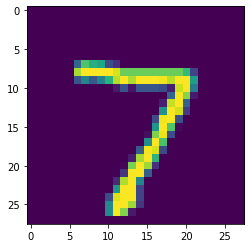

In [43]:
import tensorflow as tf
import matplotlib.pyplot as plt

plt.imshow(x_test_augmented[0].reshape(56,56))
print(y_test_regr[0])
im = tf.image.extract_glimpse(x_test_augmented[:1], (28,28), y_test_regr[:1], centered=False, normalized=False, noise='zero')
plt.imshow(tf.reshape(im, (28,28)))

In [44]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout, MaxPooling2D
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, input_shape, output_shape):
        super(MultiSplit, self).__init__()
        self.encoder = self._create_encoder(latent_dim, input_shape)
        self.input_reshaper = utils.Reshaper((n_splits, *input_shape), input_shape)
        self.latent_reshaper = utils.Reshaper([latent_dim], [n_splits * latent_dim])
        self.decoder = self._create_decoder(n_splits * latent_dim, output_shape)
        self.classifier = self._create_classifier(n_splits * latent_dim)
        self.regressor = self._create_regressor(n_splits * latent_dim)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        y_pred['decoder_out'] = tf.image.extract_glimpse(y_pred['decoder_out'], (28,28), y['regressor_out'], centered=False, normalized=False, noise='zero')
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_reco = self.decode(z ,training=training)
        y_class = self.classify(z ,training=training)
        y_regr = self.regress(z ,training=training)
        return {"decoder_out": y_reco, "classifier_out": y_class, "regressor_out": y_regr}
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=1, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Activation('sigmoid')
#             Dense(units=latent_dim, activation='sigmoid')
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 8),  #! Reduce amount of neurons by 4.
            Reshape((io_shape[0]//4, io_shape[1]//4, 8)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax', name='classifier_out')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='relu'),
            Dense(2, activation='linear', name='regressor_out')
        ])

In [45]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 1.0,
    'classifier_out' : 0.0,
    'regressor_out' : 0.0
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam')

In [46]:
history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
                    epochs=50, batch_size=32)

Epoch 1/50
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0134 - classifier_out_loss: 2.3239 - decoder_out_loss: 0.0134 - regressor_out_loss: 99.1152 - val_loss: 0.0303 - val_classifier_out_loss: 2.3220 - val_decoder_out_loss: 0.0303 - val_regressor_out_loss: 99.1840
Epoch 2/50
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0069 - classifier_out_loss: 2.3220 - decoder_out_loss: 0.0069 - regressor_out_loss: 99.1926 - val_loss: 0.0251 - val_classifier_out_loss: 2.3228 - val_decoder_out_loss: 0.0251 - val_regressor_out_loss: 99.1993
Epoch 3/50
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0060 - classifier_out_loss: 2.3228 - decoder_out_loss: 0.0060 - regressor_out_loss: 99.1944 - val_loss: 0.0226 - val_classifier_out_loss: 2.3236 - val_decoder_out_loss: 0.0226 - val_regressor_out_loss: 99.1997
Epoch 4/50
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0055 - classifier_out_loss: 2.3232 - decoder_out_l

KeyboardInterrupt: 

Classification on "old" model

In [30]:
import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
y_test = keras.utils.to_categorical(y_test)

In [31]:
from keras.models import Model
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation
from keras.utils import plot_model

# encoder
enc_input = Input(shape=(28,28,1), name='enc_input')
x  = Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', name='conv1')(enc_input)
x  = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', name='conv2')(x)
# x  = Conv2D(filters=1, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', name='pt_conv1')(x)
x = Flatten(name='flatten')(x)
latent = Dense(units=16, activation='sigmoid', name='latent')(x)

# decoder
dec_input = Input(shape=(16,), name='dec_input')
x = Dense(256, activation='relu')(dec_input)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
class_out = Dense(10, activation='softmax', name='classifier_out')(x)
# x = Dense(units=7*7*8, activation='relu', name='dense')(dec_input)
# x = Reshape(target_shape=(7,7,8), name='reshape')(x)
# x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same', name='deconv1')(x)
# x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same', name='deconv2')(x)
# dec_output = Conv2DTranspose(filters=1, kernel_size=3, padding='same', name='pt_conv')(x)

encoder = Model(enc_input, latent, name="Encoder")
decoder = Model(dec_input, class_out, name="Decoder")
model = Model(encoder.input, decoder(encoder.output))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_input (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 32)        320       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent (Dense)               (None, 16)                50192     
_________________________________________________________________
Decoder (Model)              (None, 10)                46154     
Total params: 115,162
Trainable params: 115,162
Non-trainable params: 0
_____________________________________________________

In [32]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
mc = ModelCheckpoint('../models/48_1split_orig_class.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=32, callbacks=[es, mc])

Epoch 1/100
1857/1875 [============================>.] - ETA: 0s - loss: 0.2628 - accuracy: 0.9191
Epoch 00001: val_accuracy improved from -inf to 0.96870, saving model to ../models/48_1split_orig_class.h5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2611 - accuracy: 0.9196 - val_loss: 0.0990 - val_accuracy: 0.9687
Epoch 2/100
1851/1875 [============================>.] - ETA: 0s - loss: 0.0835 - accuracy: 0.9745
Epoch 00002: val_accuracy improved from 0.96870 to 0.97970, saving model to ../models/48_1split_orig_class.h5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0834 - accuracy: 0.9746 - val_loss: 0.0629 - val_accuracy: 0.9797
Epoch 3/100
1862/1875 [============================>.] - ETA: 0s - loss: 0.0591 - accuracy: 0.9819
Epoch 00003: val_accuracy improved from 0.97970 to 0.98240, saving model to ../models/48_1split_orig_class.h5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0590 - accuracy: 0.9820 - val_loss: 0.0583 

16-split classification without translation

In [34]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, n_width, n_height):
    ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    x, y = 0, 0
    for i in range(len(data)):
#         x = np.random.randint(n_width-width)
#         y = np.random.randint(n_height-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
output_shape = (56, 56, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14
latent_dim = 4

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

In [35]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout, MaxPooling2D
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, input_shape, output_shape):
        super(MultiSplit, self).__init__()
        self.encoder = self._create_encoder(latent_dim, input_shape)
        self.input_reshaper = utils.Reshaper((n_splits, *input_shape), input_shape)
        self.latent_reshaper = utils.Reshaper([latent_dim], [n_splits * latent_dim])
        self.decoder = self._create_decoder(n_splits * latent_dim, output_shape)
        self.classifier = self._create_classifier(n_splits * latent_dim)
        self.regressor = self._create_regressor(n_splits * latent_dim)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        y_pred['decoder_out'] = tf.image.extract_glimpse(y_pred['decoder_out'], (28,28), y['regressor_out'], centered=False, normalized=False, noise='zero')
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_reco = self.decode(z ,training=training)
        y_class = self.classify(z ,training=training)
        y_regr = self.regress(z ,training=training)
        return {"decoder_out": y_reco, "classifier_out": y_class, "regressor_out": y_regr}
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=1, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Activation('sigmoid')
#             Dense(units=latent_dim, activation='sigmoid')
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 8),  #! Reduce amount of neurons by 4.
            Reshape((io_shape[0]//4, io_shape[1]//4, 8)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax', name='classifier_out')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='relu'),
            Dense(2, activation='linear', name='regressor_out')
        ])

In [36]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 0.0,
    'classifier_out' : 1.0,
    'regressor_out' : 0.0
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

In [38]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_classifier_out_accuracy', mode='max', verbose=1, patience=20)
mc = ModelCheckpoint('../models/48_1split_orig_class.h5', monitor='val_classifier_out_accuracy', mode='max', save_best_only=True, verbose=1)

history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
                    epochs=100, batch_size=32, callbacks=[es, mc])

Epoch 1/100
1873/1875 [============================>.] - ETA: 0s - loss: 0.8748 - classifier_out_loss: 0.8748 - decoder_out_loss: 0.2443 - regressor_out_loss: 101.0705 - classifier_out_accuracy: 0.7037 - decoder_out_accuracy: 0.5618 - regressor_out_accuracy: 0.0000e+00
Epoch 00001: val_classifier_out_accuracy improved from -inf to 0.86850, saving model to ../models/48_1split_orig_class.h5
1875/1875 [==============================] - 29s 15ms/step - loss: 0.8741 - classifier_out_loss: 0.8741 - decoder_out_loss: 0.2443 - regressor_out_loss: 101.0703 - classifier_out_accuracy: 0.7040 - decoder_out_accuracy: 0.5618 - regressor_out_accuracy: 0.0000e+00 - val_loss: 0.4045 - val_classifier_out_loss: 0.4045 - val_decoder_out_loss: 0.2306 - val_regressor_out_loss: 100.9339 - val_classifier_out_accuracy: 0.8685 - val_decoder_out_accuracy: 0.4868 - val_regressor_out_accuracy: 0.0000e+00
Epoch 2/100
1872/1875 [============================>.] - ETA: 0s - loss: 0.3677 - classifier_out_loss: 0.3677 -

Now 16-split with image translation

In [1]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, n_width, n_height):
    ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
#     x, y = 0, 0
    for i in range(len(data)):
        x = np.random.randint(n_width-width)
        y = np.random.randint(n_height-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
output_shape = (56, 56, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14
latent_dim = 4

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

In [2]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout, MaxPooling2D
from keras import Sequential
from keras import initializers
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, input_shape, output_shape):
        super(MultiSplit, self).__init__()
        self.encoder = self._create_encoder(latent_dim, input_shape)
        self.input_reshaper = utils.Reshaper((n_splits, *input_shape), input_shape)
        self.latent_reshaper = utils.Reshaper([latent_dim], [n_splits * latent_dim])
#         self.decoder = self._create_decoder(n_splits * latent_dim, output_shape)
        self.classifier = self._create_classifier(n_splits * latent_dim)
#         self.regressor = self._create_regressor(n_splits * latent_dim)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
#         y_pred['decoder_out'] = tf.image.extract_glimpse(y_pred['decoder_out'], (28,28), y['regressor_out'], centered=False, normalized=False, noise='zero')
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
#         y_reco = self.decode(z ,training=training)
        y_class = self.classify(z ,training=training)
#         y_regr = self.regress(z ,training=training)
#         return {"decoder_out": y_reco, "classifier_out": y_class, "regressor_out": y_regr}
        return y_class
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=1, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
#             Activation('sigmoid')
            Activation('relu')
#             Dense(units=latent_dim, activation='sigmoid')
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 8),  #! Reduce amount of neurons by 4.
            Reshape((io_shape[0]//4, io_shape[1]//4, 8)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax', name='classifier_out')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='relu'),
            Dense(2, activation='linear', name='regressor_out')
        ])

In [3]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 0.0,
    'classifier_out' : 1.0,
    'regressor_out' : 0.0
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [4]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
mc = ModelCheckpoint('../models/48_16split_trans_class.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

history = model.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=100, batch_size=32, callbacks=[es, mc])


Epoch 1/100
1868/1875 [============================>.] - ETA: 0s - loss: 1.2475 - accuracy: 0.5443
Epoch 00001: val_accuracy improved from -inf to 0.69330, saving model to ../models/48_16split_trans_class.h5
1875/1875 [==============================] - 8s 4ms/step - loss: 1.2466 - accuracy: 0.5448 - val_loss: 0.8858 - val_accuracy: 0.6933
Epoch 2/100
1870/1875 [============================>.] - ETA: 0s - loss: 0.7469 - accuracy: 0.7437
Epoch 00002: val_accuracy improved from 0.69330 to 0.77150, saving model to ../models/48_16split_trans_class.h5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7464 - accuracy: 0.7438 - val_loss: 0.6595 - val_accuracy: 0.7715
Epoch 3/100
1867/1875 [============================>.] - ETA: 0s - loss: 0.6069 - accuracy: 0.7916
Epoch 00003: val_accuracy improved from 0.77150 to 0.80470, saving model to ../models/48_16split_trans_class.h5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6064 - accuracy: 0.7918 - val_loss: 0

KeyboardInterrupt: 